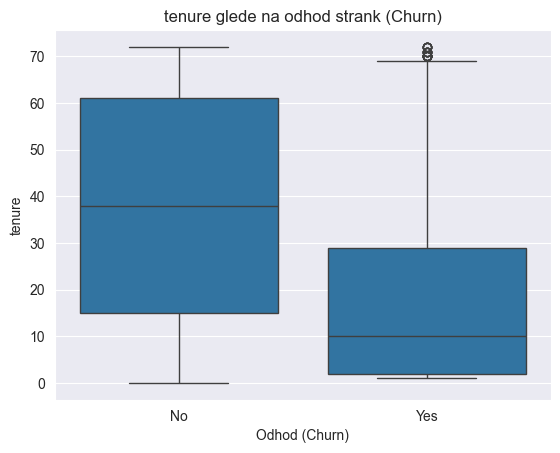

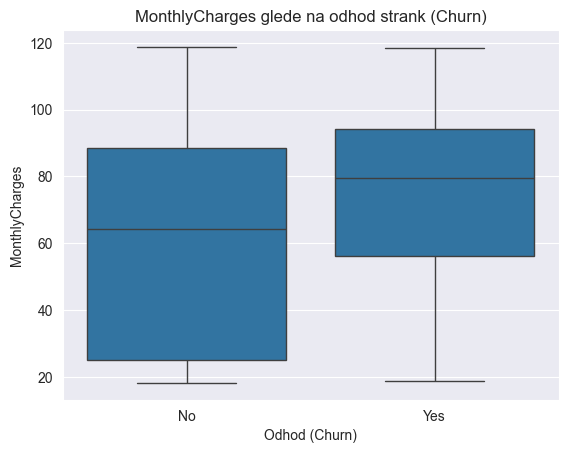

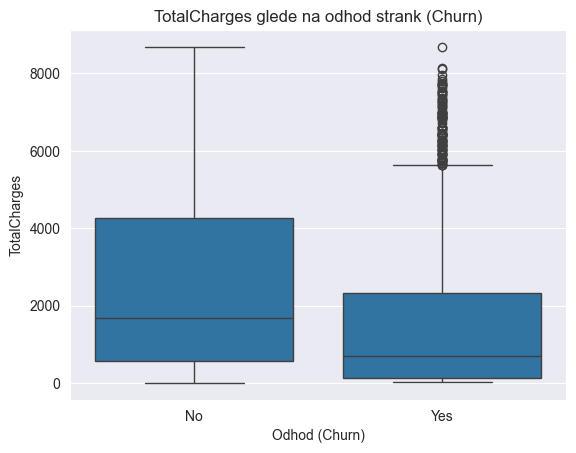

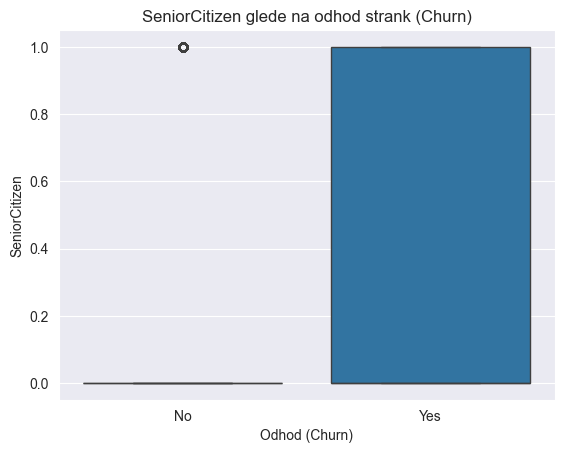

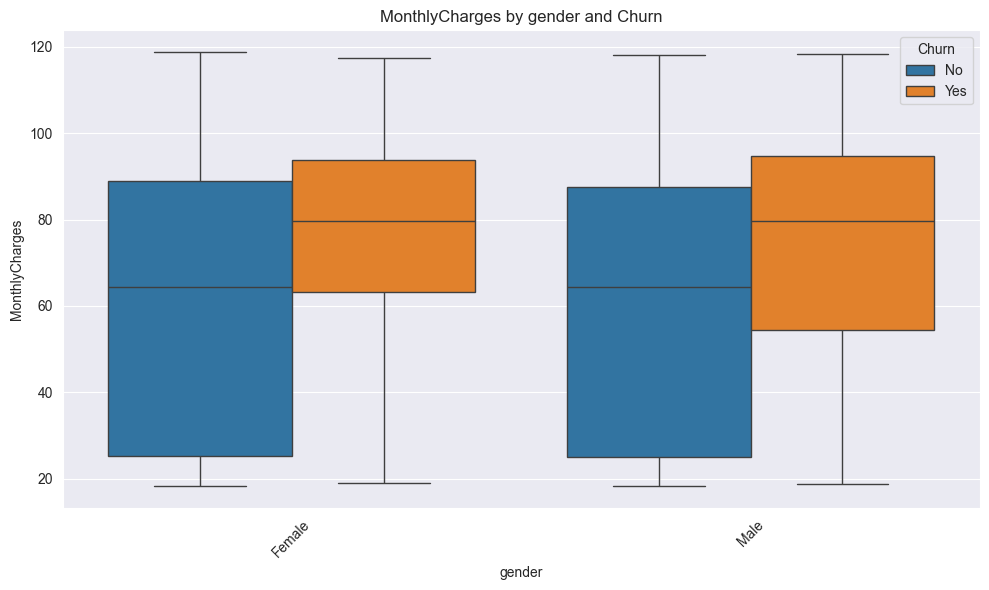

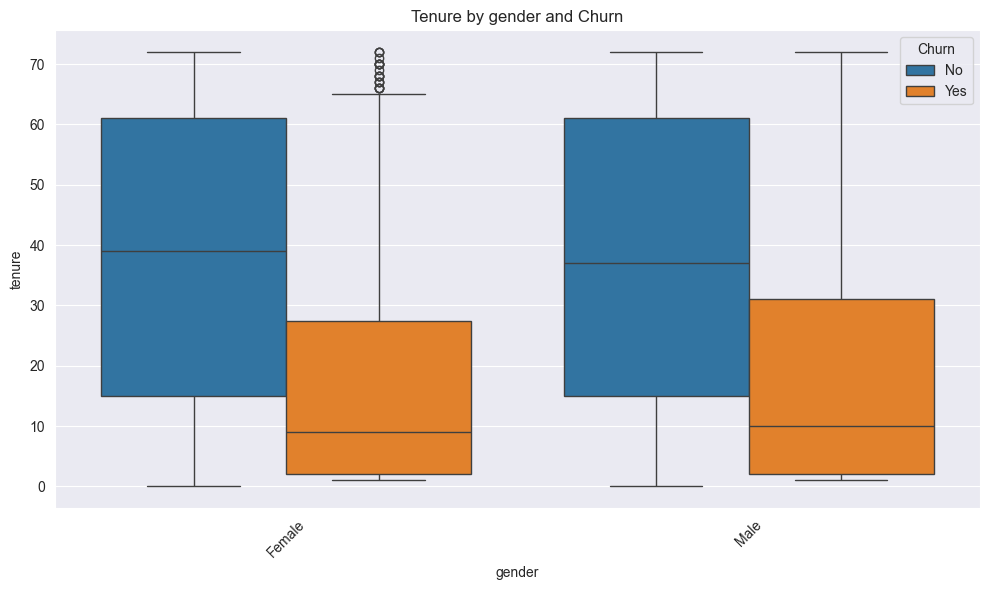

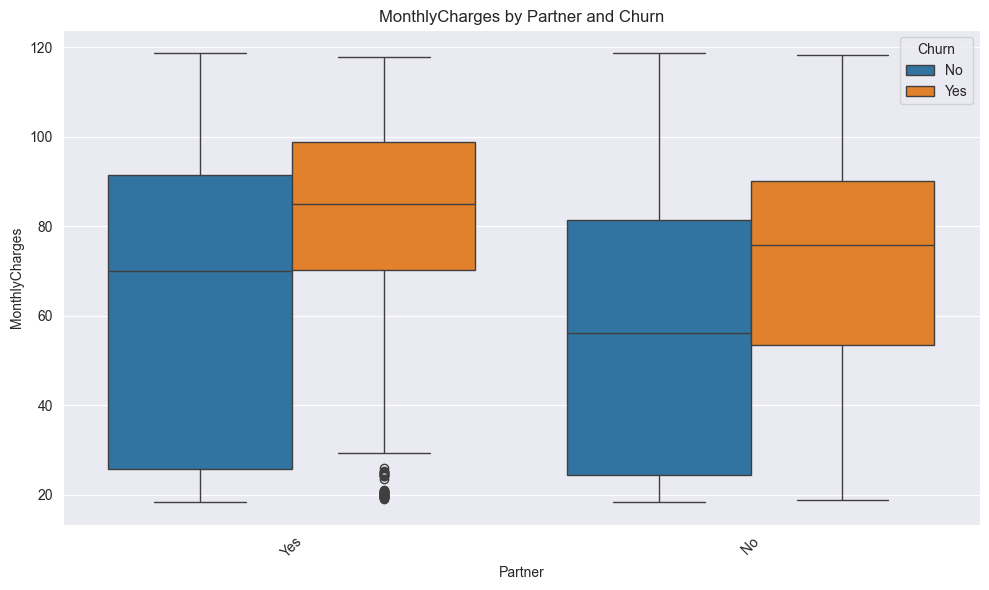

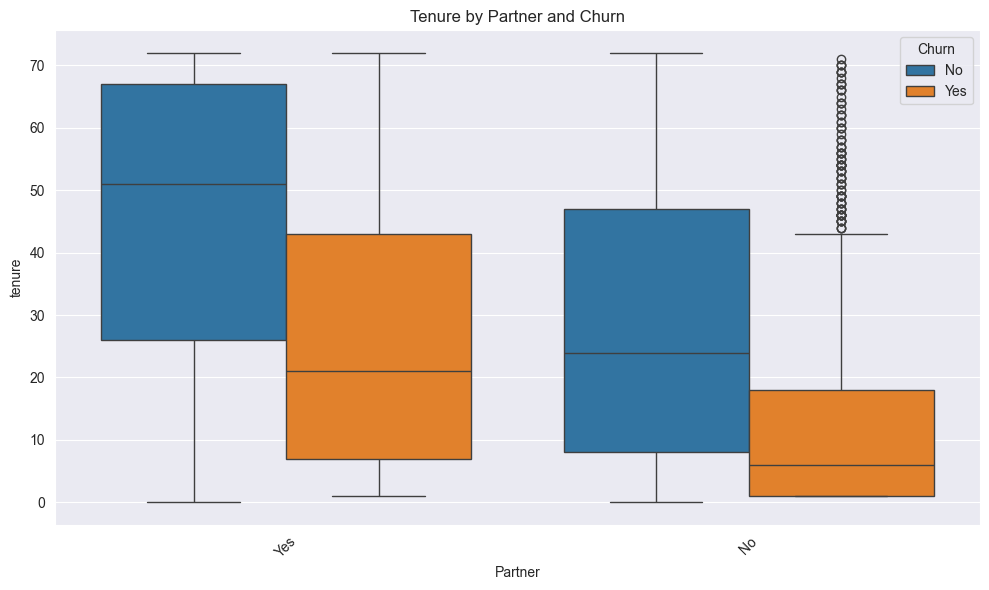

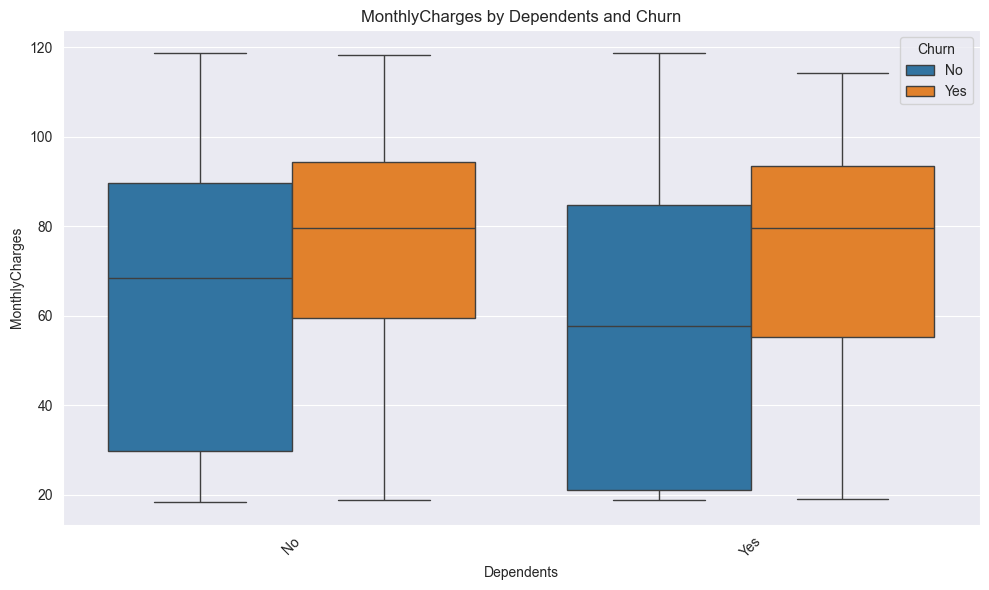

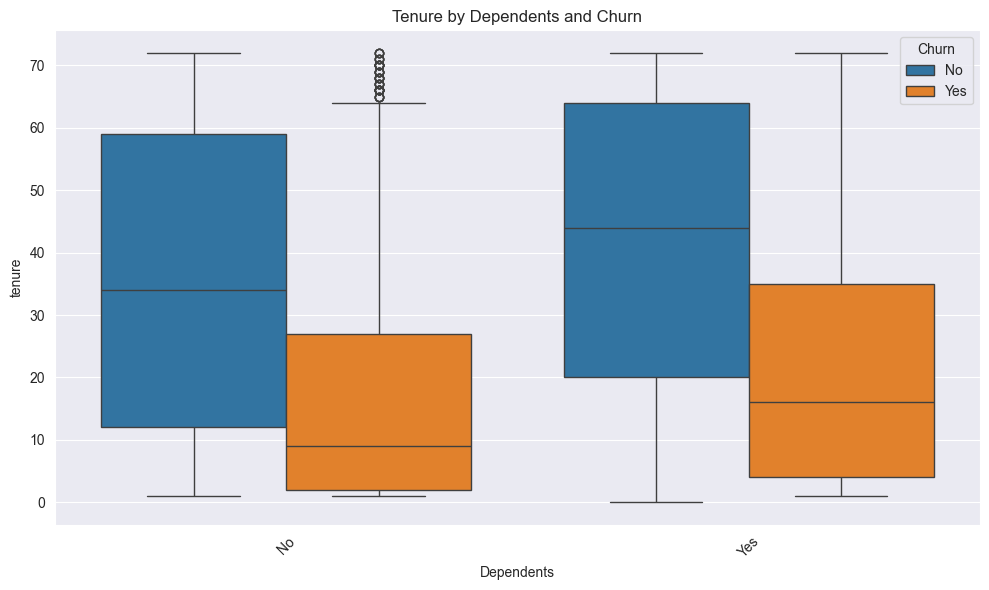

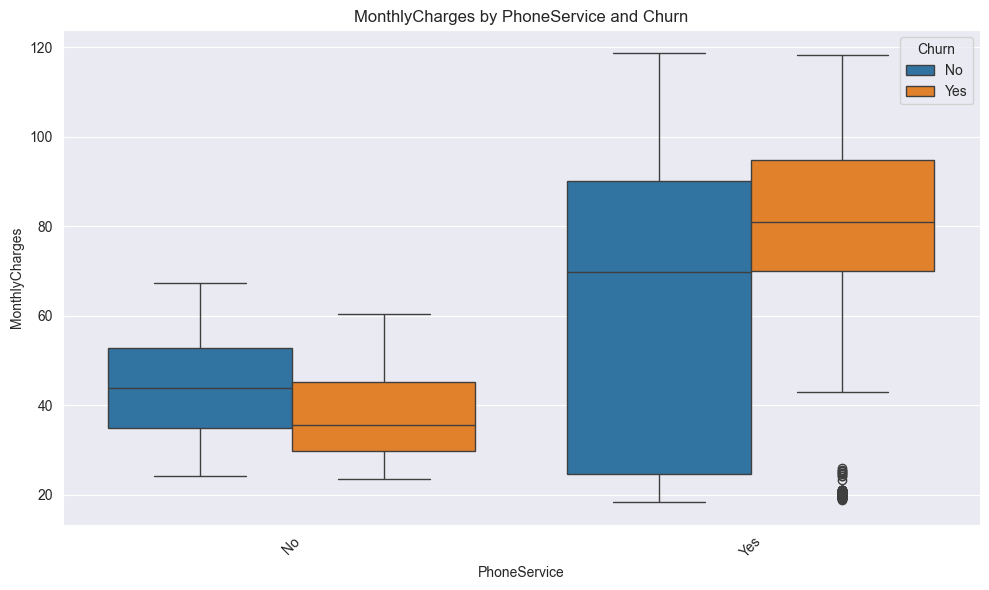

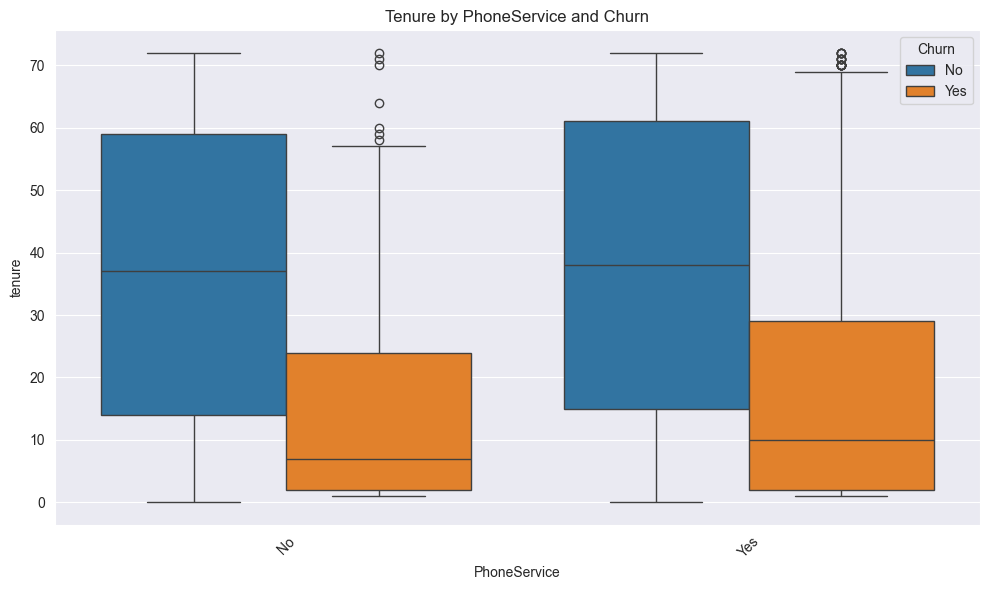

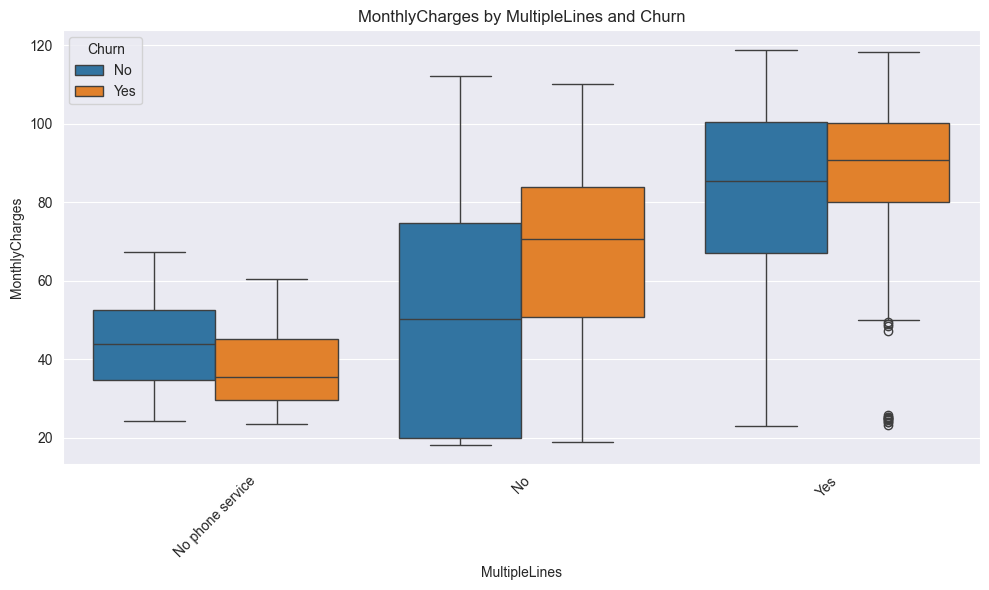

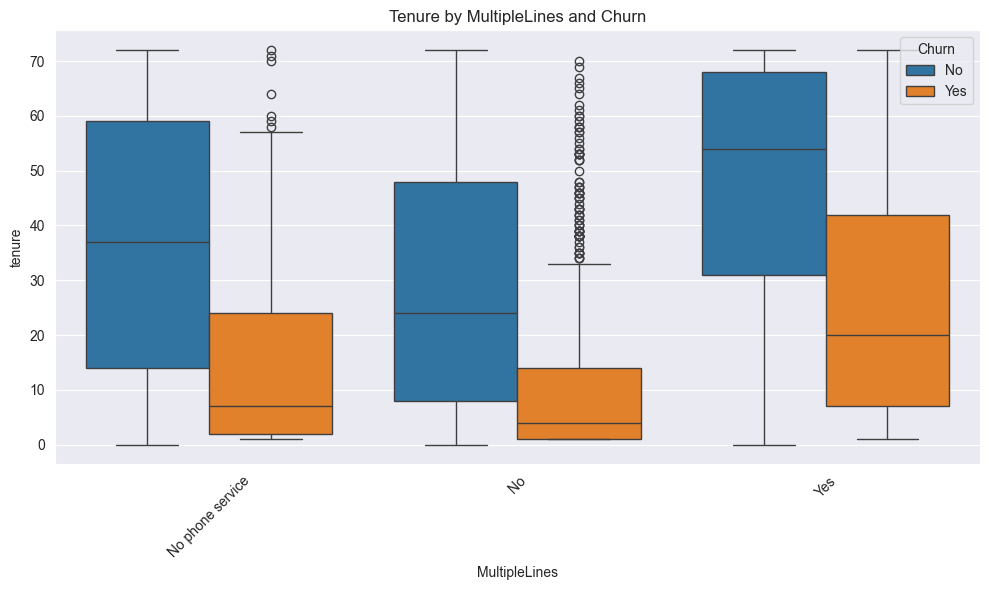

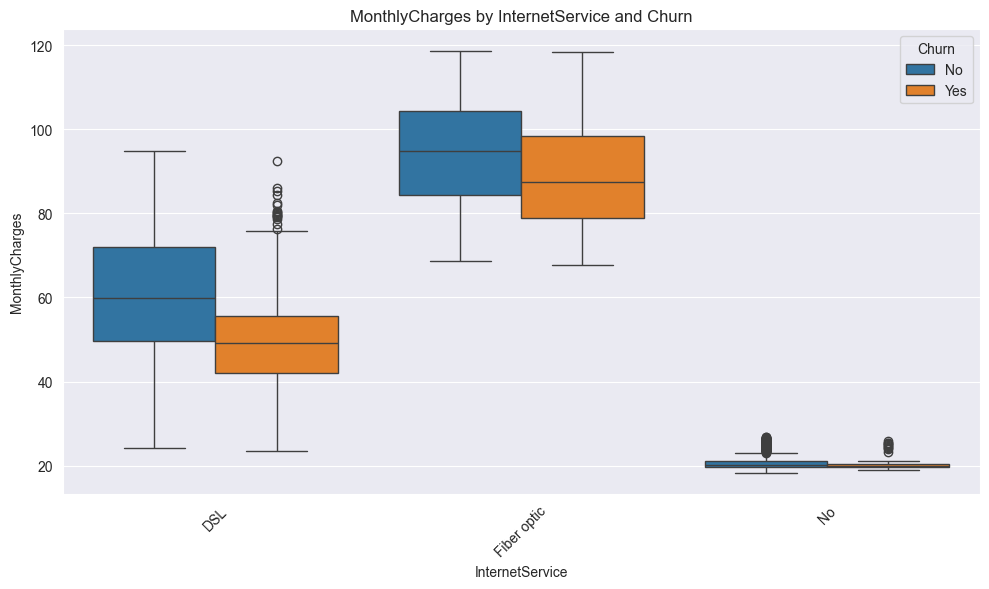

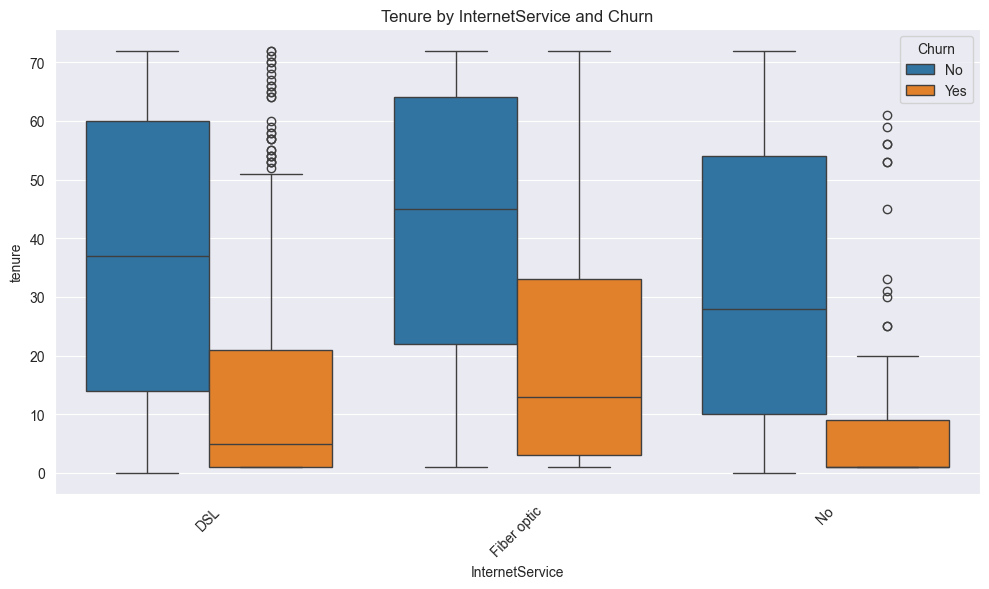

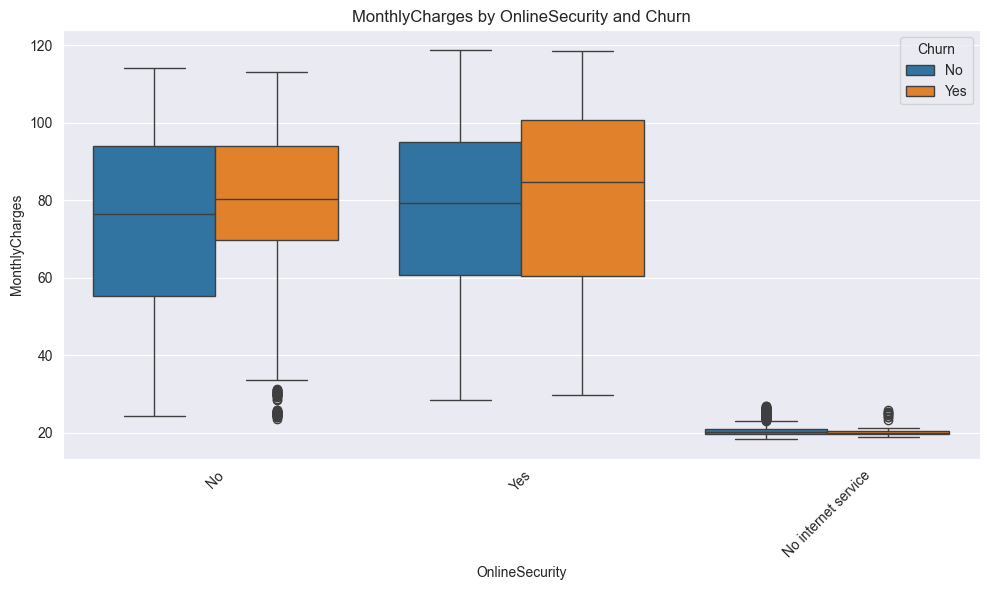

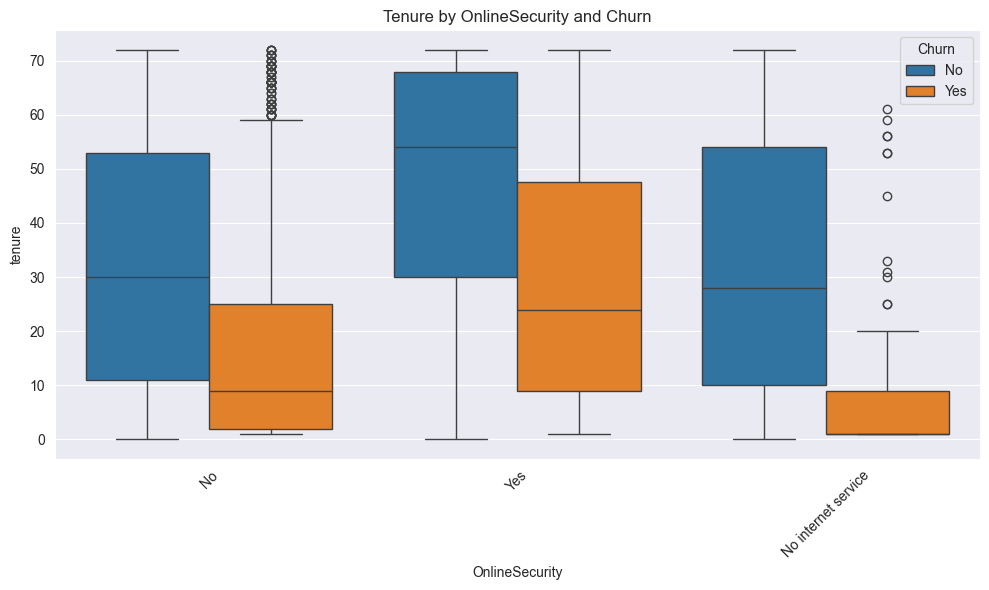

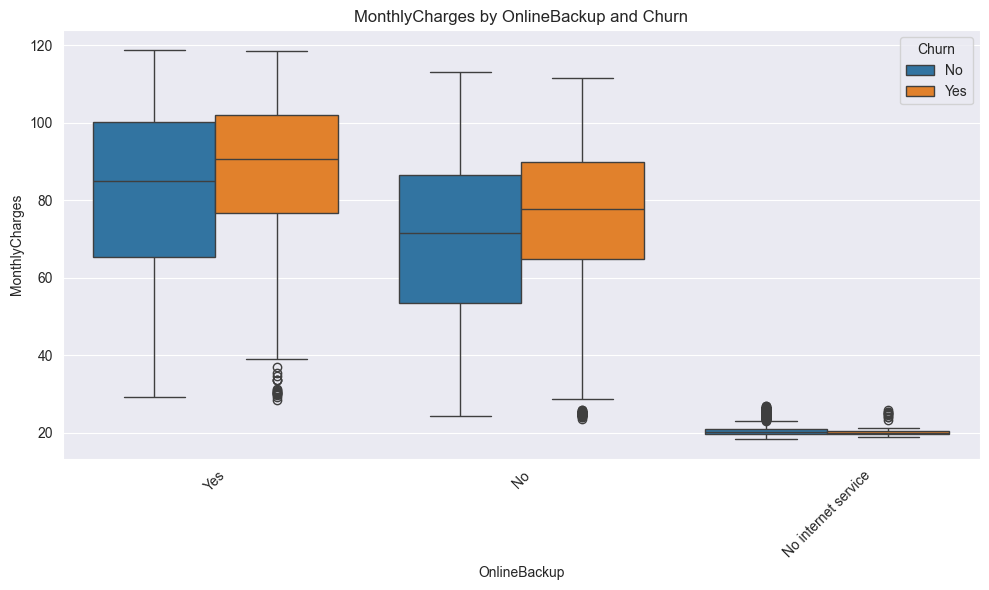

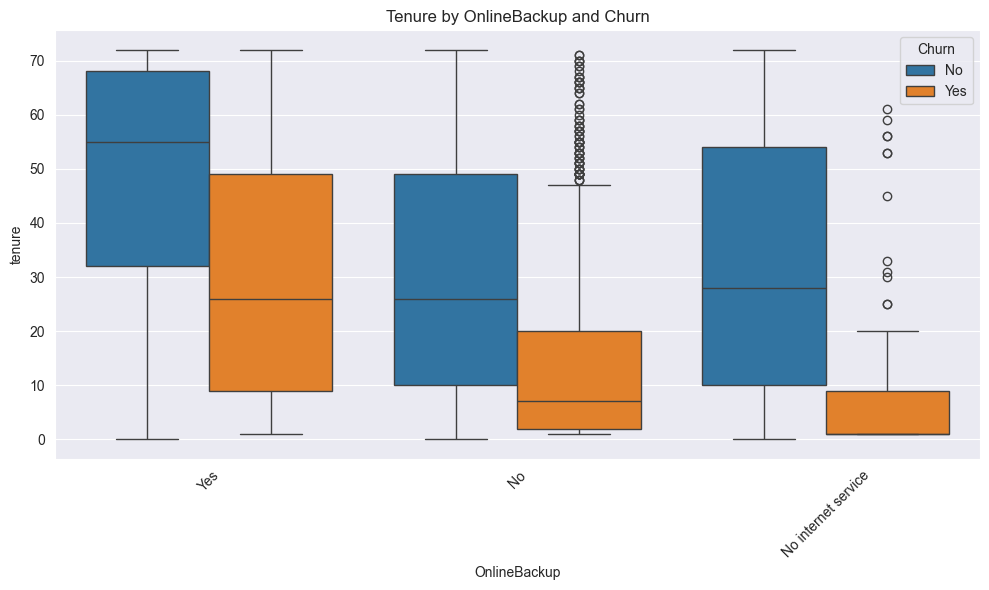

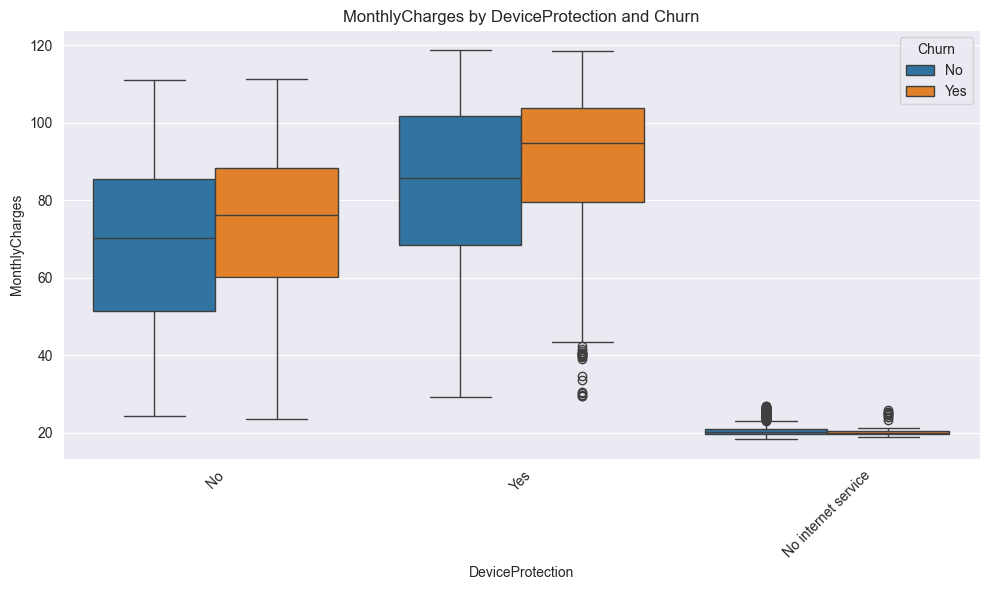

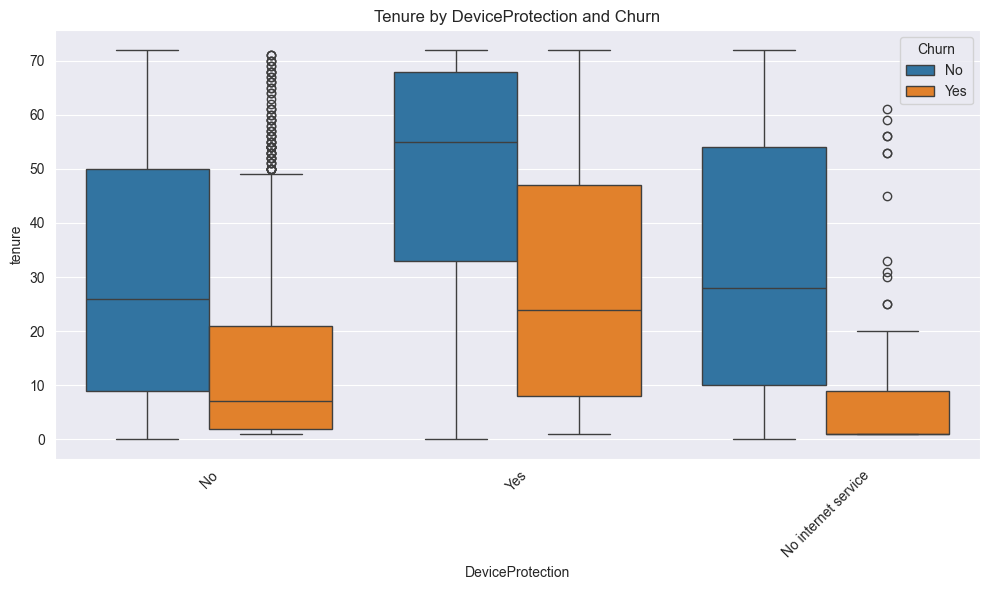

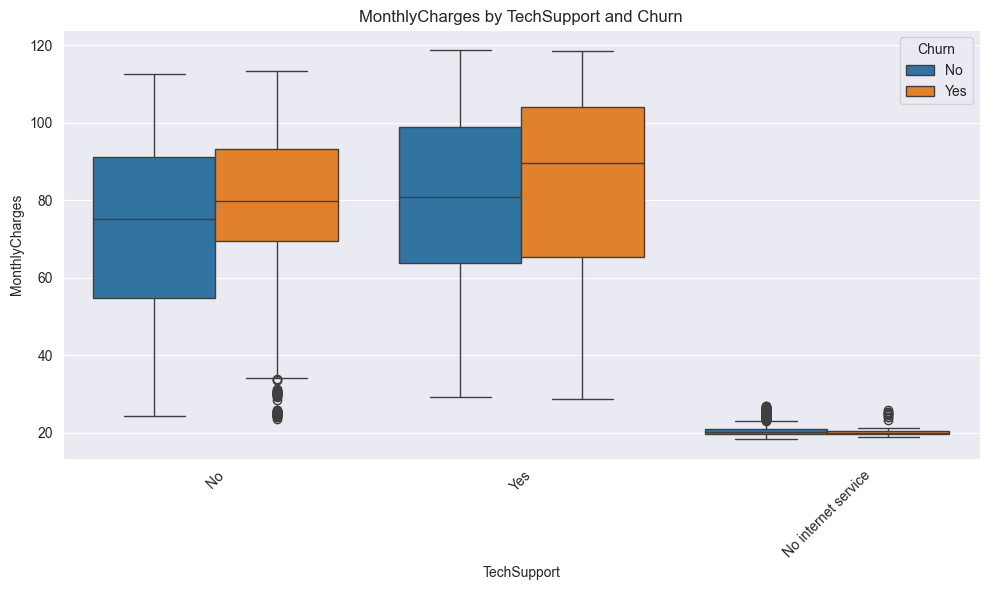

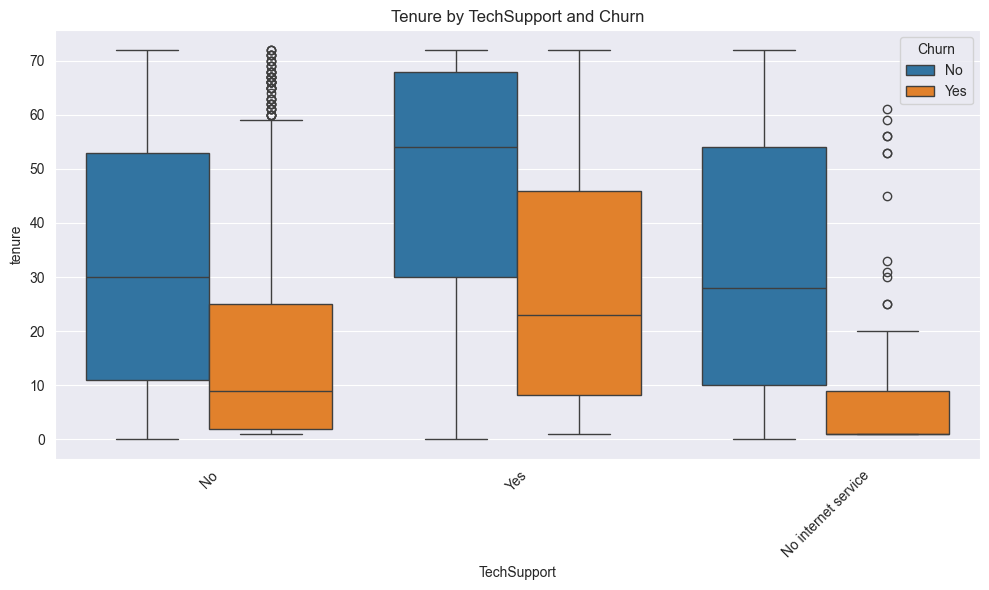

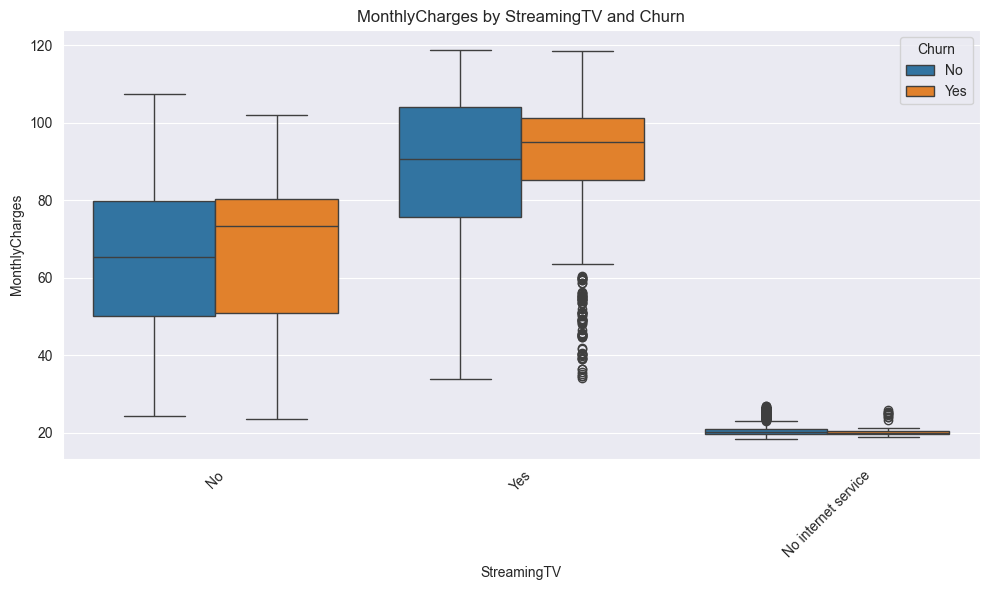

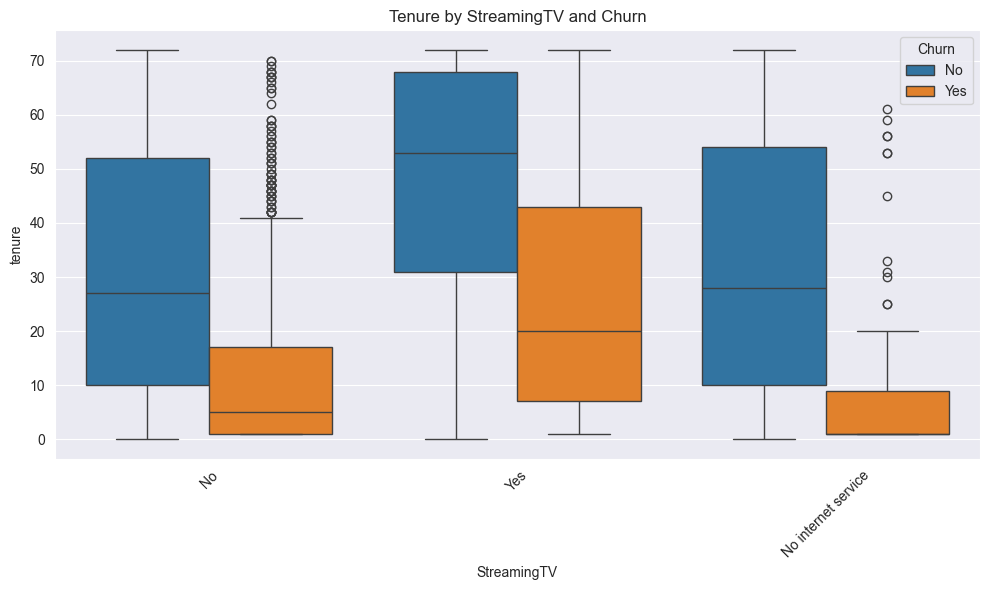

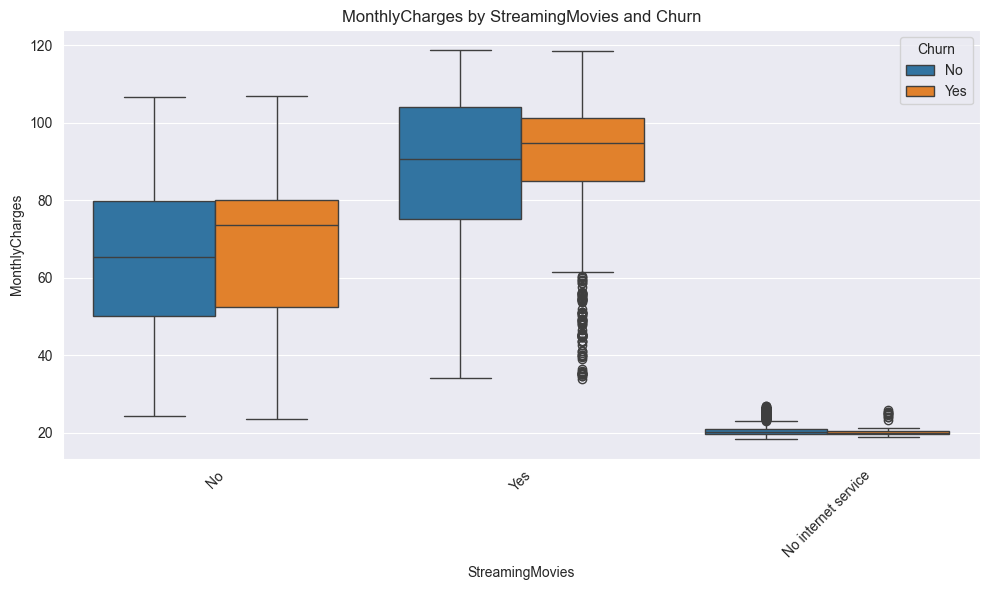

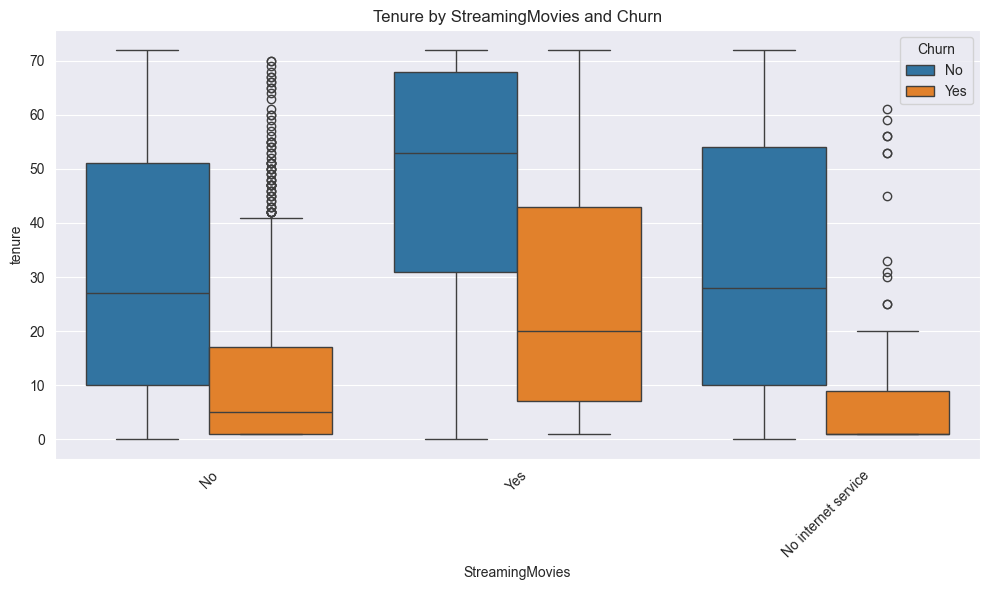

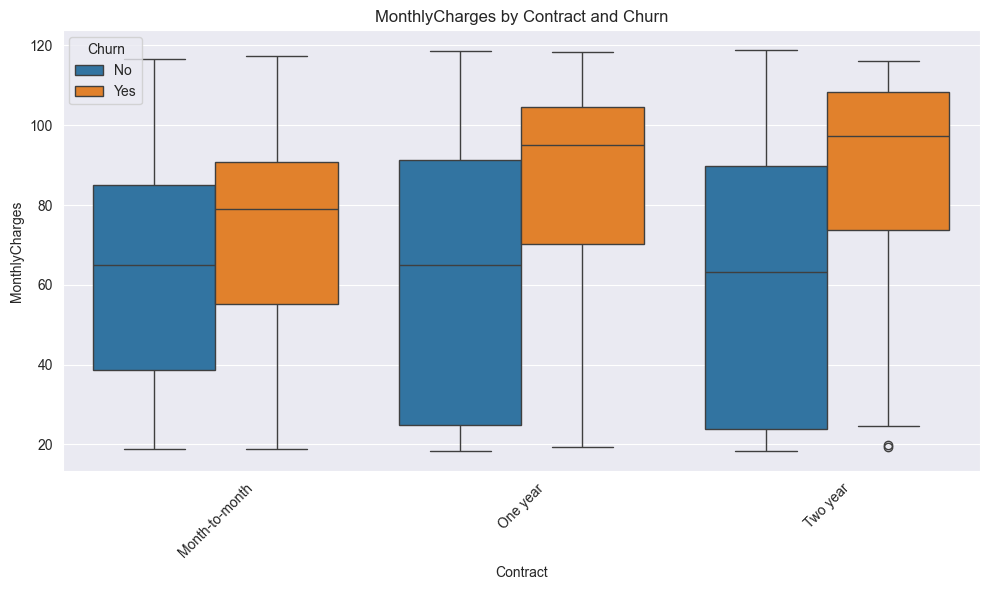

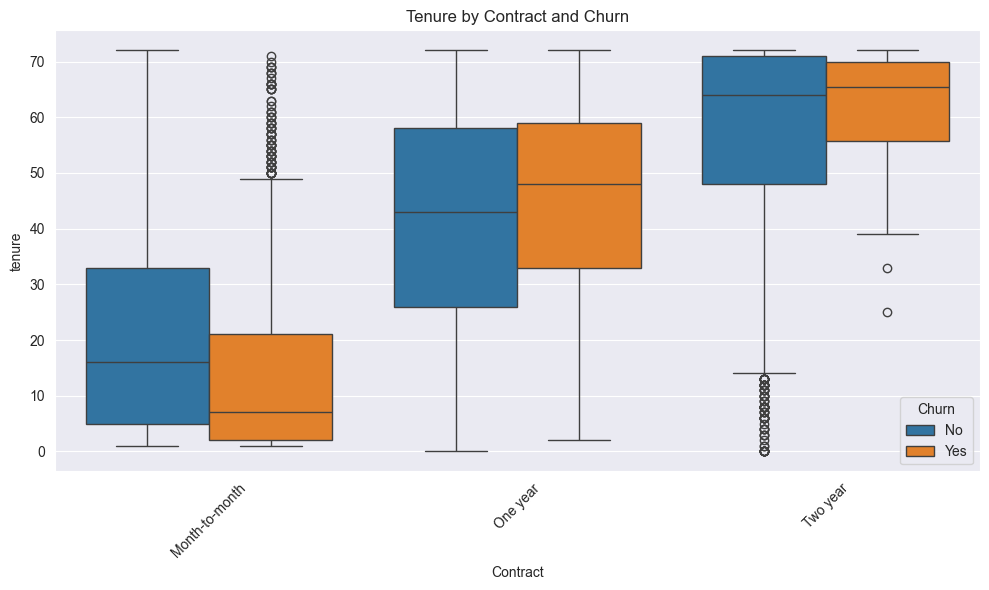

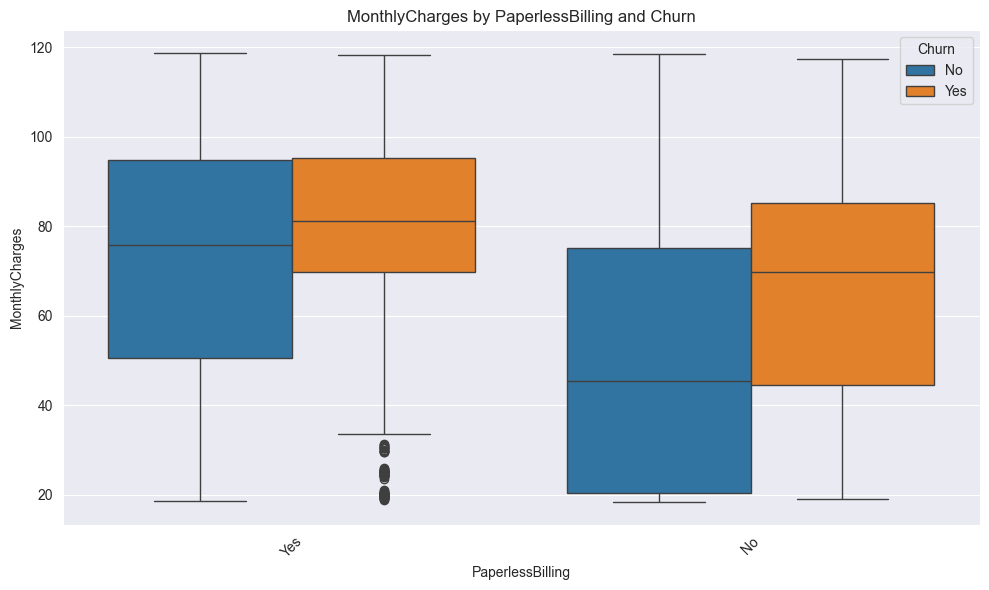

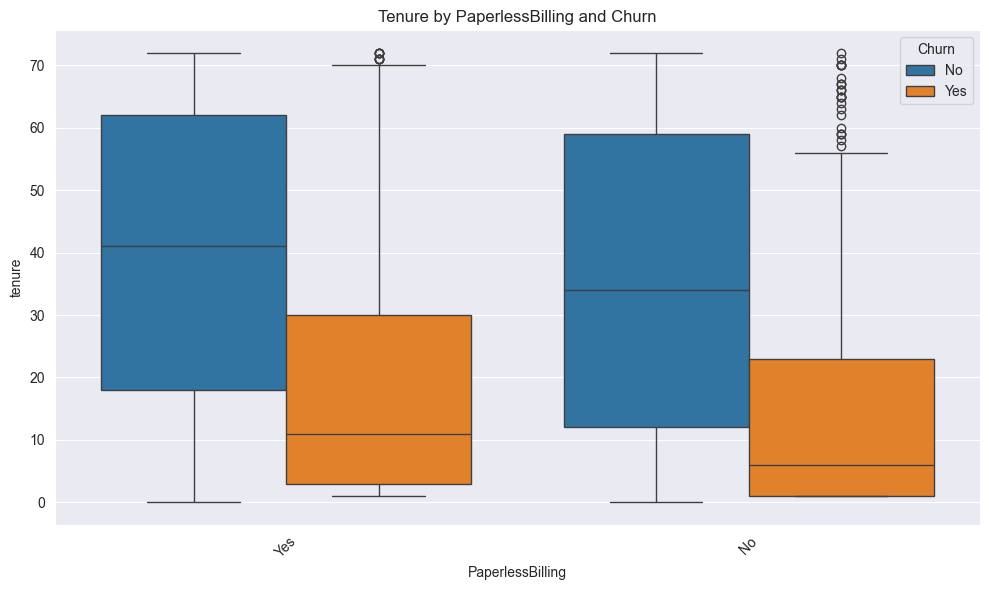

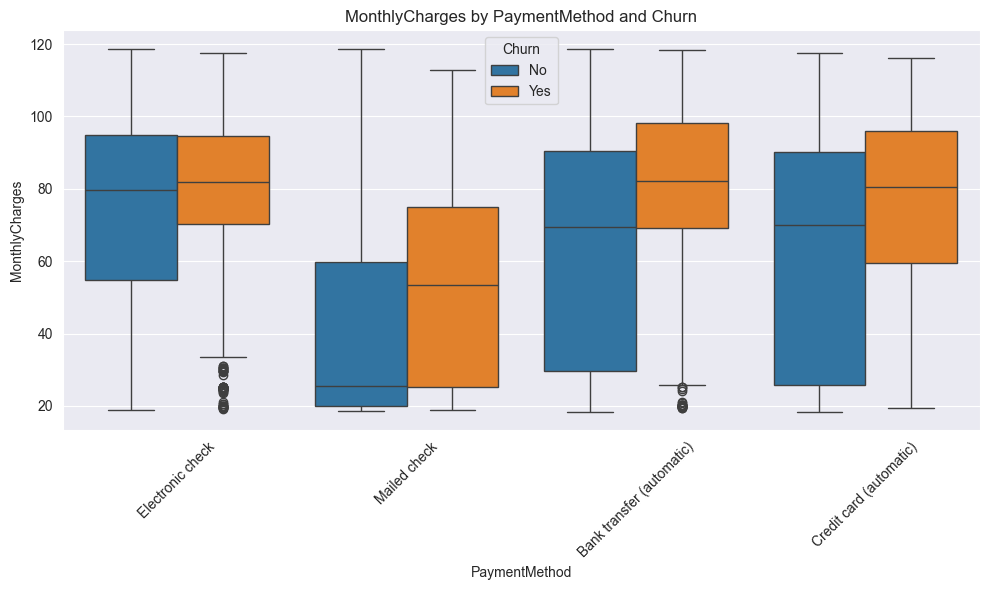

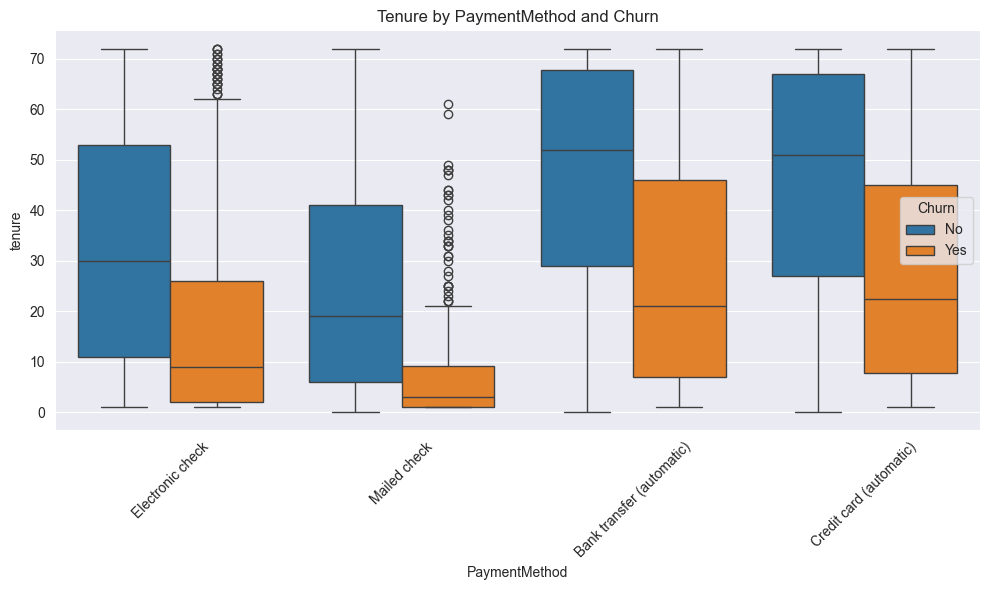


REZULTATI BIVARIATNE ANALIZE
    Spremenljivka        Tip            Test P-vrednost  \
0          tenure  Numerična  Mann–Whitney U    < 0.001   
1  MonthlyCharges  Numerična  Mann–Whitney U    < 0.001   
2    TotalCharges  Numerična  Mann–Whitney U    < 0.001   
3   SeniorCitizen  Numerična  Mann–Whitney U    < 0.001   

   Signifikantno (p < 0.05)  
0                      True  
1                      True  
2                      True  
3                      True  

NAJBOGATEJŠE FUNKCIJE PO RANDOM FOREST
                          Spremenljivka  Pomembnost
3                     num__TotalCharges    0.192685
1                           num__tenure    0.176365
2                   num__MonthlyCharges    0.173873
10     cat__InternetService_Fiber optic    0.038952
28  cat__PaymentMethod_Electronic check    0.034998
25               cat__Contract_Two year    0.031087
4                      cat__gender_Male    0.027832
13              cat__OnlineSecurity_Yes    0.027045
26            ca

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv("../Telco-Customer-Churn.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.loc[df["tenure"] == 0, "TotalCharges"] = 0
df["Churn_bin"] = df["Churn"].map({"No": 0, "Yes": 1})

results = []
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]

for col in numeric_cols:
    group_yes = df[df["Churn"] == "Yes"][col]
    group_no = df[df["Churn"] == "No"][col]

    stat, p = mannwhitneyu(group_yes, group_no, alternative="two-sided")
    p_display = "< 0.001" if p < 0.001 else round(p, 3)
    results.append({
        "Spremenljivka": col,
        "Tip": "Numerična",
        "Test": "Mann–Whitney U",
        "P-vrednost": p_display,
        "P_sort": 0.0009 if p < 0.001 else p
    })

    plt.figure()
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} glede na odhod strank (Churn)")
    plt.xlabel("Odhod (Churn)")
    plt.ylabel(col)
    plt.show()

categorical_cols = df.select_dtypes(include="object").columns.drop(["Churn", "customerID"])


for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='MonthlyCharges', hue='Churn', data=df)
    plt.title(f'MonthlyCharges by {col} and Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='tenure', hue='Churn', data=df)
    plt.title(f'Tenure by {col} and Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

bivariate_results = pd.DataFrame(results)
bivariate_results["Signifikantno (p < 0.05)"] = bivariate_results["P_sort"] < 0.05

print("\nREZULTATI BIVARIATNE ANALIZE")
print(bivariate_results.sort_values("P_sort").drop(columns="P_sort"))

X = df.drop(columns=["Churn", "Churn_bin", "customerID"])
y = df["Churn_bin"]
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])
rf.fit(X, y)
feature_names = rf.named_steps["prep"].get_feature_names_out()
rf_importance = rf.named_steps["model"].feature_importances_
rf_df = pd.DataFrame({"Spremenljivka": feature_names, "Pomembnost": rf_importance}).sort_values("Pomembnost", ascending=False)
print("\nNAJBOGATEJŠE FUNKCIJE PO RANDOM FOREST")
print(rf_df.head(15))

lasso = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        penalty="elasticnet",
        l1_ratio=1.0,
        solver="saga",
        max_iter=5000,
        C=1.0
    ))
])
lasso.fit(X, y)
lasso_coef = lasso.named_steps["model"].coef_[0]
lasso_df = pd.DataFrame({"Spremenljivka": feature_names, "Koeficient": lasso_coef})
lasso_selected = lasso_df[lasso_df["Koeficient"] != 0]
print("\nFUNKCIJE IZBRANE Z LASSO")
print(lasso_selected)

X_transformed = preprocessor.fit_transform(X)
logreg = LogisticRegression(max_iter=5000, solver="lbfgs")
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X_transformed, y)
rfe_features = feature_names[rfe.support_]
print("\nFUNKCIJE IZBRANE Z RFE")
print(rfe_features)

final_features = set(rf_df.head(15)["Spremenljivka"]).intersection(set(lasso_selected["Spremenljivka"]))
print("\nKONČNA IZBRANA FUNKCIJSKA MNOŽICA")
for f in final_features:
    print(f)


V končni funkcijski množici smo izločili nekatere spremenljivke, ki so se izkazale za manj relevantne tako z vidika statistične pomembnosti kot poslovnega pomena. Te vključujejo Gender, CustomerID, StreamingTV / StreamingMovies in PhoneService.

Gender in PhoneService nista pokazala statistično pomembne povezave z odhodom strank, kar pomeni, da ne prispevata k pojasnitvi variabilnosti ciljne spremenljivke Churn. CustomerID je unikatna identifikacijska spremenljivka vsake stranke, zato ne nosi informacije o vzorcih vedenja in jo je smiselno izločiti iz modela. Podobno so StreamingTV in StreamingMovies sicer pokazale nekatere statistične povezave, vendar pa poslovno ne pojasnjujejo ključnih dejavnikov odhoda strank, zato jih prav tako izključimo.

## Končna funkcijska množica

### Numerične spremenljivke
- `tenure`
- `MonthlyCharges`
- `TotalCharges`
- `SeniorCitizen`

### Kategorijske spremenljivke (one-hot kodirane)
- **Contract**: Month-to-month, One year, Two year
- **InternetService**: DSL, Fiber optic, No
- **TechSupport**: Yes / No
- **OnlineSecurity**: Yes / No
- **OnlineBackup**: Yes / No
- **DeviceProtection**: Yes / No
- **PaperlessBilling**: Yes / No
- **PaymentMethod**: Electronic check, Mailed check, Credit card, Bank transfer